<a href="https://colab.research.google.com/github/uelkerd/SAMO--DL/blob/main/SAMO_Voice_First_Development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/uelkerd/SAMO--DL.git
%cd SAMO--DL

fatal: destination path 'SAMO--DL' already exists and is not an empty directory.
/content/SAMO--DL


In [2]:
!apt-get install -y portaudio19-dev
!pip install pyaudio

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
portaudio19-dev is already the newest version (19.6.0-1.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [3]:
!pip install -e .


Obtaining file:///content/SAMO--DL
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for samo-dl (pyproject.toml) ... done
  Created wheel for samo-dl: filename=samo_dl-0.1.0-0.editable-py3-none-any.whl size=9008 sha256=04d7ca2c7b5ba5295fc5ec0eb144b618ec3e245052112d9b242444e1c132200a
  Stored in directory: /tmp/pip-ephem-wheel-cache-x9g26u78/wheels/6e/a1/7b/db6c8adcf5e5b2b61b3d42802962a29825761686883de61732
Successfully built samo-dl
  Attempting uninstall: samo-dl
    Found existing installation: samo-dl 0.1.0
    Uninstalling samo-dl-0.1.0:
      Successfully uninstalled samo-dl-0.1.0


In [4]:
!pip install pyaudio soundfile librosa
!pip install openai-whisper
!pip install speechrecognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 24.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for openai-whisper: filename=openai_whisper-20250625-py3-none-any.whl size=803979 sha256=ec6b79c0f8b743b889719c19bb1a87a9d9ccf2a582db25f977c8f69abe2468b4
  Stored in directory: /root/.cache/pip/wheels/32/d2/9a/801b5cc5b2a1af2e280089b71c326711a682fc1d50ea29d0ed
Successfully built openai-whisper
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 46.9 MB/s eta 0:00:00


In [5]:
!pip install torch torchaudio transformers datasets
!pip install numpy pandas scikit-learn

In [6]:
# Test audio processing
import soundfile as sf
import librosa
import whisper

print("✅ Audio libraries installed successfully!")

# Test Whisper model loading
model = whisper.load_model("base")
print("✅ Whisper model loaded successfully!")

✅ Audio libraries installed successfully!


100%|███████████████████████████████████████| 139M/139M [00:07<00:00, 20.4MiB/s]


✅ Whisper model loaded successfully!


In [65]:
# Real-time microphone input using JavaScript
from google.colab import output
from IPython.display import Javascript, Audio
import numpy as np
from scipy.io.wavfile import read, write
import io
import ffmpeg
import base64

def record_audio(duration=5, sample_rate=16000):
    """Record audio from the microphone using JavaScript."""

    js = Javascript(f"""
    async function recordAudio(duration, sampleRate) {{
      const div = document.createElement('div');
      const audio = document.createElement('audio');
      const stream = await navigator.mediaDevices.getUserMedia({{ audio: true }});
      const mediaRecorder = new MediaRecorder(stream);
      const chunks = [];

      mediaRecorder.ondataavailable = (e) => chunks.push(e.data);
      mediaRecorder.start();

      div.textContent = "🎤 Recording... Speak now!";
      document.body.appendChild(div);

      await new Promise(resolve => setTimeout(resolve, duration * 1000));

      mediaRecorder.onstop = async () => {{
        const blob = new Blob(chunks, {{ 'type' : 'audio/ogg; codecs=opus' }});
        const reader = new FileReader();
        reader.onload = () => {{
          const base64data = reader.result;
          google.colab.kernel.invokeFunction('notebook.handle_audio', [base64data], {{}});
        }};
        reader.readAsDataURL(blob);
        div.textContent = "✅ Recording complete!";
      }};

      mediaRecorder.stop();
    }}
    recordAudio({duration}, {sample_rate});
    """)
    display(js)

def handle_audio(base64data):
    """Callback function to handle the recorded audio data."""
    # Decode the base64 data
    audio_data_b64 = base64data.split(',')[1]
    decoded_audio = base64.b64decode(audio_data_b64)

    # Use ffmpeg to convert from ogg to wav
    process = (
        ffmpeg
        .input('pipe:0')
        .output('pipe:1', format='wav')
        .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True)
    )
    stdout, stderr = process.communicate(input=decoded_audio)

    # Load the wav data into a numpy array
    rate, data = read(io.BytesIO(stdout))

    # Save the audio as a wav file
    write("recorded_audio.wav", rate, data)

    print("Audio saved as recorded_audio.wav")
    display(Audio("recorded_audio.wav"))

    # Return the audio data so it can be used in the pipeline
    return (rate, data)


output.register_callback('notebook.handle_audio', handle_audio)

# Test recording
record_audio(duration=3)

<IPython.core.display.Javascript object>

Audio saved as recorded_audio.wav


In [9]:
!pip install ffmpeg-python

In [15]:
def voice_to_text(audio_frames, sample_rate=16000):
    """Convert voice to text using Whisper."""
    # Save audio to temporary file
    with wave.open("temp_audio.wav", "wb") as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)
        wf.setframerate(sample_rate)
        wf.writeframes(b''.join(audio_frames))

    # Transcribe with Whisper
    model = whisper.load_model("base")
    result = model.transcribe("temp_audio.wav")

    return result["text"]

# Test voice-to-text
text = voice_to_text(audio_frames)
print(f"🎤 You said: {text}")

NameError: name 'audio_frames' is not defined

In [16]:
def detect_emotion_from_voice(audio_frames, sample_rate=16000):
    """Detect emotion from voice using audio features."""
    import librosa
    import numpy as np

    # Convert audio frames to numpy array
    audio_data = np.frombuffer(b''.join(audio_frames), dtype=np.int16)
    audio_data = audio_data.astype(np.float32) / 32768.0

    # Extract audio features
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=13)
    spectral_centroids = librosa.feature.spectral_centroid(y=audio_data, sr=sample_rate)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(audio_data)

    # Calculate statistics
    features = {
        'mfcc_mean': np.mean(mfccs),
        'mfcc_std': np.std(mfccs),
        'spectral_centroid_mean': np.mean(spectral_centroids),
        'zero_crossing_rate_mean': np.mean(zero_crossing_rate)
    }

    # Simple emotion mapping (can be enhanced with ML model)
    if features['spectral_centroid_mean'] > 2000:
        emotion = "excited"
    elif features['mfcc_mean'] < -5:
        emotion = "sad"
    else:
        emotion = "neutral"

    return emotion, features

# Test emotion detection
emotion, features = detect_emotion_from_voice(audio_frames)
print(f"😊 Detected emotion: {emotion}")

NameError: name 'audio_frames' is not defined

In [17]:
!ls -l SAMO--DL/examples

ls: cannot access 'SAMO--DL/examples': No such file or directory


In [18]:
!ls -l SAMO--DL

ls: cannot access 'SAMO--DL': No such file or directory


In [20]:
!pwd

/content/SAMO--DL


In [21]:
!ls -l

total 132
drwxr-xr-x 2 root root  4096 Jul 29 21:56 configs
drwxr-xr-x 6 root root  4096 Jul 29 21:56 data
drwxr-xr-x 2 root root  4096 Jul 29 21:56 docker
drwxr-xr-x 2 root root  4096 Jul 29 21:56 docs
-rw-r--r-- 1 root root  1868 Jul 29 21:56 environment.yml
-rwxr-xr-x 1 root root  4458 Jul 29 21:56 gcp_deeplearning_images_fix.sh
-rw-r--r-- 1 root root 14157 Jul 29 21:56 gcp_deploy_automation.sh
-rwxr-xr-x 1 root root  5034 Jul 29 21:56 gcp_quick_fix.sh
-rwxr-xr-x 1 root root  3685 Jul 29 21:56 gpu_zone_finder.sh
drwxr-xr-x 5 root root  4096 Jul 29 21:56 models
drwxr-xr-x 2 root root  4096 Jul 29 21:56 notebooks
-rw-r--r-- 1 root root   484 Jul 29 21:56 package.json
-rw-r--r-- 1 root root  4760 Jul 29 21:56 package-lock.json
drwxr-xr-x 2 root root  4096 Jul 29 21:56 prisma
-rw-r--r-- 1 root root 11202 Jul 29 21:56 pyproject.toml
-rw-r--r-- 1 root root 19995 Jul 29 21:56 README.md
drwxr-xr-x 5 root root  4096 Jul 29 21:56 scripts
drwxr-xr-x 8 root root  4096 Jul 29 21:56 src
drwxr-xr-

In [22]:
!ls -l notebooks

total 236
-rw-r--r-- 1 root root 241570 Jul 29 21:56 data_pipeline_demo.ipynb


In [24]:
import json

with open("/content/SAMO--DL/notebooks/data_pipeline_demo.ipynb", "r") as f:
    notebook_content = json.load(f)

for cell in notebook_content["cells"]:
    if cell["cell_type"] == "code":
        print("".join(cell["source"]))

# Import required libraries
import logging
import os
import sys
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Configure logging
logging.basicConfig(
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s", level=logging.INFO
)

# Add parent directory to path to import project modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# Import project modules
from src.data.embeddings import EmbeddingPipeline, TfidfEmbedder, Word2VecEmbedder
from src.data.feature_engineering import FeatureEngineer
from src.data.loaders import save_entries_to_csv
from src.data.pipeline import DataPipeline
from src.data.preprocessing import JournalEntryPreprocessor, TextPreprocessor
from src.data.sample_data import (
    generate_journal_entries,
    load_sample_entries,
    save_entries_to_json,
)
from src.data.validation import DataValidator

# Set up plotting
plt.style.use("seaborn-v0_8-whitegrid")

In [26]:
!pip install pgvector

In [28]:
%run /content/SAMO--DL/notebooks/data_pipeline_demo.ipynb

ImportError: cannot import name 'generate_journal_entries' from 'src.data.sample_data' (/content/SAMO--DL/src/data/sample_data.py)

ImportError: cannot import name 'generate_journal_entries' from 'src.data.sample_data' (/content/SAMO--DL/src/data/sample_data.py)

In [29]:
!cat /content/SAMO--DL/src/data/sample_data.py

import json
import random
from datetime import datetime, timezone, timedelta
from pathlib import Path
from typing import Any, Optional

import pandas as pd

# Sample topics to generate journal entries about
TOPICS = [
    "work",
    "family",
    "health",
    "exercise",
    "food",
    "travel",
    "learning",
    "hobbies",
    "goals",
    "emotions",
    "relationships",
    "finance",
    "home",
    "pets",
    "nature",
    "dreams",
    "reflection",
]

# Emotion categories for entries
EMOTIONS = [
    "happy",
    "sad",
    "anxious",
    "excited",
    "calm",
    "frustrated",
    "hopeful",
    "tired",
    "grateful",
    "overwhelmed",
    "proud",
    "content",
]

# Templates for journal entry content
ENTRY_TEMPLATES = [
    "Today I felt {emotion} about {topic}. {additional_sentence}",
    "I spent time on {topic} today. {additional_sentence} Overall I'm feeling {emotion}.",
    "I've been thinking a lot about {topic} lately. {additional_sentence} It makes me feel 

In [59]:
import time
import os
from scipy.io.wavfile import read

def samo_voice_pipeline():
    """Complete SAMO voice-first processing pipeline."""
    print("🎤 SAMO Voice-First Pipeline")
    print("=" * 40)

    # Step 1: Record voice
    print("1️⃣ Recording your voice...")
    record_audio(duration=5)

    # Wait for the audio file to be created
    time.sleep(6)

    # Check if the audio file exists
    if not os.path.exists("recorded_audio.wav"):
        print("Error: Audio recording failed.")
        return

    # Step 2: Convert to text
    print("2️⃣ Converting voice to text...")
    rate, data = read("recorded_audio.wav")
    text = voice_to_text(data, sample_rate=rate)
    print(f"   Text: {text}")

    # Step 3: Detect emotion from voice
    print("3️⃣ Detecting emotion from voice...")
    voice_emotion, voice_features = detect_emotion_from_voice(data, sample_rate=rate)
    print(f"   Voice emotion: {voice_emotion}")

    # Step 4: Detect emotion from text
    print("4️⃣ Detecting emotion from text...")
    # Load SAMO emotion detection model
    model = SimpleBERTEmotionClassifier()
    text_emotions = model.predict_emotions(text)
    print(f"   Text emotions: {text_emotions}")

    # Step 5: Combine results
    print("5️⃣ Combining voice and text analysis...")
    combined_analysis = {
        'text': text,
        'voice_emotion': voice_emotion,
        'text_emotions': text_emotions,
        'confidence': 0.85  # Can be calculated from model confidence
    }

    return combined_analysis

# Test complete pipeline
result = samo_voice_pipeline()
if result:
    print(f"\n🎉 SAMO Analysis Complete!")
    print(f"📝 Text: {result['text']}")
    print(f"🎤 Voice Emotion: {result['voice_emotion']}")
    print(f"📄 Text Emotions: {result['text_emotions']}")

🎤 SAMO Voice-First Pipeline
1️⃣ Recording your voice...


<IPython.core.display.Javascript object>

2️⃣ Converting voice to text...
   Text: 
3️⃣ Detecting emotion from voice...
   Voice emotion: excited
4️⃣ Detecting emotion from text...
   Text emotions: [[0.5468888  0.52280664 0.4581626  0.3953996  0.6573637  0.521246
  0.4301133  0.586742   0.2913617  0.58082217 0.5214305  0.38087717
  0.53497815 0.5636129  0.403861   0.573655   0.49728775 0.547932
  0.4516394  0.5553476  0.38364604 0.5475097  0.3899775  0.4859066
  0.57969624 0.494976   0.65068156 0.51518387]]
5️⃣ Combining voice and text analysis...

🎉 SAMO Analysis Complete!
📝 Text: 
🎤 Voice Emotion: excited
📄 Text Emotions: [[0.5468888  0.52280664 0.4581626  0.3953996  0.6573637  0.521246
  0.4301133  0.586742   0.2913617  0.58082217 0.5214305  0.38087717
  0.53497815 0.5636129  0.403861   0.573655   0.49728775 0.547932
  0.4516394  0.5553476  0.38364604 0.5475097  0.3899775  0.4859066
  0.57969624 0.494976   0.65068156 0.51518387]]


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Audio saved as recorded_audio.wav


In [56]:
# G004: Logging f-strings temporarily allowed for development
"""BERT Emotion Classifier for SAMO Deep Learning.

This module implements the BERT-based emotion detection model following the
training strategies from the model training playbook for 27-category emotion
classification with multi-label support.

Key Features:
- BERT-base-uncased foundation with emotional fine-tuning
- Multi-label classification with sigmoid activation
- Progressive unfreezing strategy for transfer learning
- Class-weighted loss for imbalanced data handling
- Temperature scaling for confidence calibration
"""

import logging
import time
import warnings
from typing import Optional, Union
import sys
import os

# Add the src directory to the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import f1_score, precision_recall_fscore_support
from torch.utils.data import DataLoader, Dataset
from transformers import (
    AutoConfig,
    AutoModel,
    AutoTokenizer,
)

from data.dataset_loader import GOEMOTIONS_EMOTIONS

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)


class BERTEmotionClassifier(nn.Module):
    """BERT-based emotion classifier for multi-label emotion detection.

    Architecture:
    - BERT-base-uncased backbone
    - Two-layer classification head for non-linear feature combination
    - Sigmoid activation for independent emotion predictions
    - Dropout regularization to prevent overfitting
    """

    def __init__(
        self,
        model_name: str = "bert-base-uncased",
        num_emotions: int = 28,  # 27 emotions + neutral
        hidden_dropout_prob: float = 0.3,
        classifier_dropout_prob: float = 0.5,
        freeze_bert_layers: int = 0,
        temperature: float = 1.0,  # Temperature scaling for calibration
    ) -> None:
        """Initialize BERT emotion classifier.

        Args:
            model_name: Hugging Face model name
            num_emotions: Number of emotion categories (27 + neutral)
            hidden_dropout_prob: Dropout rate for BERT hidden layers
            classifier_dropout_prob: Dropout rate for classification head
            freeze_bert_layers: Number of BERT layers to freeze initially
            temperature: Temperature scaling parameter for probability calibration
        """
        super().__init__()

        self.model_name = model_name
        self.num_emotions = num_emotions
        self.hidden_dropout_prob = hidden_dropout_prob
        self.classifier_dropout_prob = classifier_dropout_prob
        self.freeze_bert_layers = freeze_bert_layers
        self.temperature = temperature
        self.prediction_threshold = 0.6  # Updated from 0.5 to 0.6 based on calibration

        # Initialize device attribute
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Load BERT configuration and modify for our task
        config = AutoConfig.from_pretrained(model_name)
        config.hidden_dropout_prob = hidden_dropout_prob
        config.attention_probs_dropout_prob = hidden_dropout_prob

        # Initialize BERT backbone
        self.bert = AutoModel.from_pretrained(model_name, config=config)

        # Get BERT hidden size (768 for bert-base)
        self.bert_hidden_size = config.hidden_size

        # Two-layer classification head for non-linear feature combination
        self.classifier = nn.Sequential(
            nn.Dropout(classifier_dropout_prob),
            nn.Linear(self.bert_hidden_size, self.bert_hidden_size),
            nn.ReLU(),
            nn.Dropout(classifier_dropout_prob),
            nn.Linear(self.bert_hidden_size, self.num_emotions),
        )

        # Temperature parameter for confidence calibration
        self.temperature = nn.Parameter(torch.ones(1))

        # Initialize classification layers with Xavier initialization
        self._init_classification_layers()

        # Apply initial layer freezing if specified
        if freeze_bert_layers > 0:
            self._freeze_bert_layers(freeze_bert_layers)

        # Move the model to the correct device
        self.to(self.device)

        logger.info(
            f"Initialized BERT emotion classifier with {self.count_parameters():,} parameters"
        )

    def _init_classification_layers(self) -> None:
        """Initialize classification layers with Xavier initialization."""
        for module in self.classifier:
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.constant_(module.bias, 0)

    def _freeze_bert_layers(self, num_layers: int) -> None:
        """Freeze specified number of BERT layers for progressive unfreezing.

        Args:
            num_layers: Number of layers to freeze (0 = none, 12 = all)
        """
        # Freeze embedding layer
        for param in self.bert.embeddings.parameters():
            param.requires_grad = False

        # Freeze specified number of encoder layers
        for i in range(min(num_layers, len(self.bert.encoder.layer))):
            for param in self.bert.encoder.layer[i].parameters():
                param.requires_grad = False

        logger.info(f"Frozen {num_layers} BERT layers for progressive training")

    def unfreeze_bert_layers(self, num_layers: int) -> None:
        """Unfreeze BERT layers for progressive unfreezing strategy.

        Args:
            num_layers: Number of additional layers to unfreeze
        """
        # Unfreeze embedding layer if unfreezing any layers
        if num_layers > 0:
            for param in self.bert.embeddings.parameters():
                param.requires_grad = True

        # Calculate which layers to unfreeze
        total_layers = len(self.bert.encoder.layer)
        currently_frozen = sum(
            1 for layer in self.bert.encoder.layer if not next(layer.parameters()).requires_grad
        )

        layers_to_unfreeze = min(num_layers, currently_frozen)
        start_layer = total_layers - currently_frozen

        # Unfreeze layers from the top
        for i in range(start_layer, start_layer + layers_to_unfreeze):
            for param in self.bert.encoder.layer[i].parameters():
                param.requires_grad = True

        logger.info(f"Unfroze {layers_to_unfreeze} additional BERT layers")

    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: torch.Tensor,
        token_type_ids: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        """Forward pass through BERT emotion classifier.

        Args:
            input_ids: Token IDs from BERT tokenizer
            attention_mask: Attention mask for padding tokens
            token_type_ids: Token type IDs (optional)

        Returns:
            Logits tensor for emotion predictions
        """
        # BERT forward pass
        bert_outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            output_attentions=False,
        )

        # Use [CLS] token representation for classification
        pooled_output = bert_outputs.pooler_output

        # Classification head
        logits = self.classifier(pooled_output)

        # Apply temperature scaling for calibration
        calibrated_logits = logits / self.temperature

        # For internal use, we'll store these as attributes
        self._calibrated_logits = calibrated_logits
        self._probabilities = torch.sigmoid(calibrated_logits)

        # Return calibrated logits for evaluation
        return calibrated_logits

    def set_temperature(self, temperature: float) -> None:
        """Update temperature parameter for calibration.

        Args:
            temperature: New temperature value (>0). Higher values = lower confidence.
        """
        if temperature <= 0:
            raise ValueError("Temperature must be positive")

        # Correctly update the parameter's value in-place
        with torch.no_grad():
            self.temperature.fill_(temperature)

        logger.info(f"Updated temperature to {temperature}")

    def predict_emotions(
        self,
        texts: Union[str, list[str]],
        threshold: float = 0.5,
        top_k: Optional[int] = None,
    ) -> dict[str, Union[list[str], torch.Tensor, list[float]]]:
        """Predict emotions for input text with confidence scores.

        Args:
            texts: Input text(s) to analyze
            threshold: Probability threshold for emotion prediction
            top_k: Return top K emotions regardless of threshold

        Returns:
            Dictionary with predicted emotions, probabilities, and confidence info
        """
        self.eval()

        # Handle single text vs list of texts
        if isinstance(texts, str):
            texts = [texts]

        # Tokenize input texts
        tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        encoded = tokenizer(
            texts, padding=True, truncation=True, max_length=512, return_tensors="pt"
        )

        input_ids = encoded["input_ids"].to(self.device)
        attention_mask = encoded["attention_mask"].to(self.device)

        with torch.no_grad():
            # Forward pass returns logits directly now
            _ = self.forward(input_ids, attention_mask)
            # Use the stored probabilities attribute
            probabilities = self._probabilities.cpu().numpy()

        # Handle batch dimension
        if probabilities.ndim == 2:
            probabilities = probabilities[0]  # Take first example if batch

        # Get emotion predictions
        if top_k is not None:
            # Return top K emotions
            top_indices = np.argsort(probabilities)[-top_k:][::-1]
            predicted_emotions = [GOEMOTIONS_EMOTIONS[i] for i in top_indices]
            emotion_scores = probabilities[top_indices].tolist()
        else:
            # Use threshold-based prediction
            predicted_indices = np.where(probabilities >= threshold)[0]
            predicted_emotions = [GOEMOTIONS_EMOTIONS[i] for i in predicted_indices]
            emotion_scores = probabilities[predicted_indices].tolist()

        # Get primary emotion (highest probability)
        primary_emotion_idx = np.argmax(probabilities)
        primary_emotion = GOEMOTIONS_EMOTIONS[primary_emotion_idx]
        primary_confidence = probabilities[primary_emotion_idx]

        return {
            "predicted_emotions": predicted_emotions,
            "emotion_scores": emotion_scores,
            "primary_emotion": primary_emotion,
            "primary_confidence": float(primary_confidence),
            "all_probabilities": probabilities.tolist(),
            "emotion_mapping": dict(zip(GOEMOTIONS_EMOTIONS, probabilities.tolist())),
        }

    def count_parameters(self) -> int:
        """Count total trainable parameters."""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def get_frozen_parameters(self) -> int:
        """Count frozen parameters."""
        return sum(p.numel() for p in self.parameters() if not p.requires_grad)


class WeightedBCELoss(nn.Module):
    """Weighted Binary Cross Entropy Loss for imbalanced multi-label classification.

    Implements class weighting to handle emotion frequency imbalance in GoEmotions.
    """

    def __init__(
        self, class_weights: Optional[torch.Tensor] = None, reduction: str = "mean"
    ) -> None:
        """Initialize weighted BCE loss.

        Args:
            class_weights: Tensor of shape [num_classes] with class weights
            reduction: Loss reduction method ('mean', 'sum', 'none')
        """
        super().__init__()
        self.class_weights = class_weights
        self.reduction = reduction

        if class_weights is not None:
            logger.info(
                f"Initialized WeightedBCELoss with class weights: min={class_weights.min():.3f}, max={class_weights.max():.3f}"
            )

ModuleNotFoundError: No module named 'data.dataset_loader'

In [41]:
!pip install datasets
from datasets import load_dataset

# Load the GoEmotions dataset
dataset = load_dataset("go_emotions", "raw")

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/24.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/211225 [00:00<?, ? examples/s]

In [42]:
import torch
from torch import nn
from transformers import AutoTokenizer, AutoModel
import numpy as np

class SimpleBERTEmotionClassifier(nn.Module):
    def __init__(self, model_name="bert-base-uncased", num_emotions=28):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.bert = AutoModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_emotions)
        self.to(self.device)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)
        return logits

    def predict_emotions(self, text):
        self.eval()
        tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        encoded = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt")
        input_ids = encoded["input_ids"].to(self.device)
        attention_mask = encoded["attention_mask"].to(self.device)

        with torch.no_grad():
            logits = self.forward(input_ids, attention_mask)
            probabilities = torch.sigmoid(logits)

        return probabilities.cpu().numpy()


In [47]:
!cat /content/SAMO--DL/src/data/feature_engineering.py

# G004: Logging f-strings temporarily allowed for development
import logging
import re

import nltk
import numpy as np
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

# Configure logging
logging.basicConfig(
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s", level=logging.INFO
)
logger = logging.getLogger(__name__)


class FeatureEngineer:
    """Feature engineering for journal entries."""

    def __init__(self) -> None:
        """Initialize feature engineer."""
        # Ensure NLTK resources are downloaded
        try:
            nltk.download("vader_lexicon", quiet=True)
            self.sentiment_analyzer = SentimentIntensityAnalyzer()
        except Exception:
            logger.error(
                "Failed to initialize sentiment analyzer: {e}",
                extra={"format_args": True},
            )
            self.sentime

In [49]:
!cat /content/SAMO--DL/src/data/embeddings.py

# G004: Logging f-strings temporarily allowed for development
import logging

import numpy as np
import pandas as pd
from gensim.models import FastText, Word2Vec
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import TfidfVectorizer

# Configure logging
logging.basicConfig(
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s", level=logging.INFO
)
logger = logging.getLogger(__name__)


class BaseEmbedder:
    """Base class for text embedding models."""

    def __init__(self) -> None:
        self.model = None

    def fit(self, texts: list[str]) -> "BaseEmbedder":
        """Fit the embedding model on a list of texts.

        Args:
            texts: List of texts to fit the model on

        Returns:
            Self for chaining

        """
        msg = "Subclasses must implement fit()"
        raise NotImplementedError(msg)

    def transform(self, texts: list[str]) -> np.ndarray:
        """Transform texts into embeddings.

        A

In [51]:
!cat /content/SAMO--DL/src/data/pipeline.py

# G004: Logging f-strings temporarily allowed for development
import logging
from datetime import UTC, datetime
from pathlib import Path

import pandas as pd

from .embeddings import (
    EmbeddingPipeline,
    FastTextEmbedder,
    TfidfEmbedder,
    Word2VecEmbedder,
)
from .feature_engineering import FeatureEngineer
from .loaders import (
    load_entries_from_csv,
    load_entries_from_db,
    load_entries_from_json,
)
from .preprocessing import JournalEntryPreprocessor
from .validation import DataValidator

# Configure logging
logging.basicConfig(
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s", level=logging.INFO
)
logger = logging.getLogger(__name__)


class DataPipeline:
    """Orchestrator for the journal entry data processing pipeline."""

    def __init__(
        self,
        preprocessor: JournalEntryPreprocessor | None = None,
        validator: DataValidator | None = None,
        feature_engineer: FeatureEngineer | None = None,
        embedding_meth

In [53]:
!cat /content/SAMO--DL/src/data/pipeline.py

# G004: Logging f-strings temporarily allowed for development
import logging
from datetime import UTC, datetime
from pathlib import Path

import pandas as pd

from .embeddings import (
    EmbeddingPipeline,
    FastTextEmbedder,
    TfidfEmbedder,
    Word2VecEmbedder,
)
from .feature_engineering import FeatureEngineer
from .loaders import (
    load_entries_from_csv,
    load_entries_from_db,
    load_entries_from_json,
)
from .preprocessing import JournalEntryPreprocessor
from .validation import DataValidator

# Configure logging
logging.basicConfig(
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s", level=logging.INFO
)
logger = logging.getLogger(__name__)


class DataPipeline:
    """Orchestrator for the journal entry data processing pipeline."""

    def __init__(
        self,
        preprocessor: JournalEntryPreprocessor | None = None,
        validator: DataValidator | None = None,
        feature_engineer: FeatureEngineer | None = None,
        embedding_meth

In [55]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [63]:
import sys
import os
import pandas as pd
from datetime import datetime, timezone

# Add parent directory to path to import project modules
# This is necessary for the imports from 'src' to work correctly.
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from src.data.pipeline import DataPipeline
from src.data.validation import DataValidator
from src.data.preprocessing import JournalEntryPreprocessor
from src.data.feature_engineering import FeatureEngineer
from src.data.embeddings import EmbeddingPipeline, TfidfEmbedder, Word2VecEmbedder
from src.data.sample_data import generate_entries # Using the correct function name

# 1. Generate sample data
print("Generating sample data...")
entries = generate_entries(
    num_entries=200, num_users=10, start_date=datetime.now(timezone.utc) - pd.Timedelta(days=90)
)
sample_df = pd.DataFrame(entries)
print(f"Generated {len(sample_df)} journal entries.")


# 2. Initialize the data pipeline
print("\nInitializing the data processing pipeline...")
pipeline = DataPipeline(
    validator=DataValidator(),
    preprocessor=JournalEntryPreprocessor(),
    feature_engineer=FeatureEngineer(),
    embedding_method='tfidf'
)
print("Pipeline initialized.")

# 3. Process the data
print("\nProcessing data with the pipeline...")
results = pipeline.run(sample_df, source_type='dataframe', extract_topics=True)
processed_data = results['featured']
topics_df = results['topics']
print("Data processing complete.")

# 4. Display results
print(f"\nPipeline input shape: {sample_df.shape}")
print(f"Pipeline output shape: {processed_data.shape}")

new_columns = [col for col in processed_data.columns if col not in sample_df.columns]
print(f"\nFeatures added by pipeline: {len(new_columns)}")
print(new_columns)

print("\nSample of processed data:")
display(processed_data.head())

print("\nTop words per topic:")
display(topics_df)

Generating sample data...
Generated 200 journal entries.

Initializing the data processing pipeline...
Pipeline initialized.

Processing data with the pipeline...
Data processing complete.

Pipeline input shape: (200, 9)
Pipeline output shape: (200, 44)

Features added by pipeline: 35
['text_length', 'word_count', 'is_empty', 'is_very_short', 'full_text', 'processed_text', 'char_count', 'sentence_count', 'avg_word_length', 'words_per_sentence', 'unique_word_count', 'lexical_diversity', 'sentiment_negative', 'sentiment_neutral', 'sentiment_positive', 'sentiment_compound', 'sentiment_category', 'year', 'month', 'day', 'day_of_week', 'is_weekend', 'hour', 'time_of_day', 'topic_1_score', 'topic_2_score', 'topic_3_score', 'topic_4_score', 'topic_5_score', 'topic_6_score', 'topic_7_score', 'topic_8_score', 'topic_9_score', 'topic_10_score', 'dominant_topic']

Sample of processed data:


,id,user_id,title,content,created_at,updated_at,is_private,topic,emotion,text_length,...,topic_2_score,topic_3_score,topic_4_score,topic_5_score,topic_6_score,topic_7_score,topic_8_score,topic_9_score,topic_10_score,dominant_topic
0,1,8,pets update,My pets journey continues. I've been discussin...,2025-07-25 13:54:21.343753+00:00,2025-07-25 13:54:21.343753+00:00,False,pets,tired,95,...,0.233316,0.410440,0.132782,0.130634,-0.046416,-0.196764,0.067536,-0.037765,0.184832,3
1,2,1,Today's travel experience,travel has been on my mind. It's important for...,2025-05-05 12:06:03.343753+00:00,2025-05-05 12:06:03.343753+00:00,False,travel,tired,107,...,-0.079453,0.004313,0.149978,-0.082388,-0.083566,0.055810,0.189373,0.032179,-0.168974,8
2,3,10,Processing my home feelings,My thoughts on home today: I'm making good pro...,2025-06-11 21:38:50.343753+00:00,2025-06-11 21:38:50.343753+00:00,False,home,anxious,68,...,0.034344,0.124176,-0.095158,-0.041367,-0.030825,-0.286917,0.053905,0.071205,0.114093,1
3,4,3,relationships update,relationships has been on my mind. It's been a...,2025-06-05 13:36:24.343753+00:00,2025-06-05 13:36:24.343753+00:00,True,relationships,frustrated,107,...,0.042980,0.260946,-0.027554,-0.198454,-0.188225,0.137363,0.024190,0.146005,0.033006,1
4,5,7,Processing my learning feelings,I spent time on learning today. I'm trying dif...,2025-06-29 07:21:36.343753+00:00,2025-06-29 07:21:36.343753+00:00,True,learning,frustrated,119,...,-0.440345,-0.100948,-0.395624,0.161099,-0.421445,0.069928,-0.157436,-0.086283,0.073188,1



Top words per topic:


,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
0,today,thinking,journey,left,ve,taken,spent,things,need,today
1,ve,makes,progress,experience,proud,expected,overall,hoping,balance,friends
2,feeling,lot,continues,far,far,time,feeling,soon,focus,discussing
3,feel,ve,proud,accomplished,accomplished,felt,time,improve,area,left
4,lately,lately,ups,proud,friends,activities,ve,mind,home,experience


In [57]:
!pip install datasets
from datasets import load_dataset

# Load the GoEmotions dataset
dataset = load_dataset("go_emotions", "raw")

In [58]:
import torch
from torch import nn
from transformers import AutoTokenizer, AutoModel
import numpy as np

class SimpleBERTEmotionClassifier(nn.Module):
    def __init__(self, model_name="bert-base-uncased", num_emotions=28):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.bert = AutoModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_emotions)
        self.to(self.device)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)
        return logits

    def predict_emotions(self, text):
        self.eval()
        tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        encoded = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt")
        input_ids = encoded["input_ids"].to(self.device)
        attention_mask = encoded["attention_mask"].to(self.device)

        with torch.no_grad():
            logits = self.forward(input_ids, attention_mask)
            probabilities = torch.sigmoid(logits)

        return probabilities.cpu().numpy()

In [60]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [62]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [81]:
import time
import os
from scipy.io.wavfile import read

def samo_voice_pipeline():
    """Complete SAMO voice-first processing pipeline."""
    print("🎤 SAMO Voice-First Pipeline")
    print("=" * 40)

    # Step 1: Record voice
    print("1️⃣ Recording your voice...")
    record_audio(duration=5)

    # Wait for the audio file to be created
    time.sleep(6)

    # Check if the audio file exists
    if not os.path.exists("recorded_audio.wav"):
        print("Error: Audio recording failed.")
        return

    # Step 2: Convert to text
    print("2️⃣ Converting voice to text...")
    rate, data = read("recorded_audio.wav")
    text = voice_to_text(data, sample_rate=rate)
    print(f"   Text: {text}")

    # Step 3: Detect emotion from voice
    print("3️⃣ Detecting emotion from voice...")
    voice_emotion, voice_features = detect_emotion_from_voice(data, sample_rate=rate)
    print(f"   Voice emotion: {voice_emotion}")

    # Step 4: Detect emotion from text
    print("4️⃣ Detecting emotion from text...")
    # Load SAMO emotion detection model
    model = SimpleBERTEmotionClassifier()
    text_emotions = model.predict_emotions(text)
    print(f"   Text emotions: {text_emotions}")

    # Step 5: Combine results
    print("5️⃣ Combining voice and text analysis...")
    combined_analysis = {
        'text': text,
        'voice_emotion': voice_emotion,
        'text_emotions': text_emotions,
        'confidence': 0.85  # Can be calculated from model confidence
    }

    return combined_analysis

# Test complete pipeline
result = samo_voice_pipeline()
if result:
    print(f"\n🎉 SAMO Analysis Complete!")
    print(f"📝 Text: {result['text']}")
    print(f"🎤 Voice Emotion: {result['voice_emotion']}")
    print(f"📄 Text Emotions: {result['text_emotions']}")

🎤 SAMO Voice-First Pipeline
1️⃣ Recording your voice...


<IPython.core.display.Javascript object>

2️⃣ Converting voice to text...
   Text:  Hey, how are you doing today? I'm not so good today.
3️⃣ Detecting emotion from voice...
   Voice emotion: excited
4️⃣ Detecting emotion from text...
   Text emotions: [[0.60394704 0.44535553 0.50218564 0.52149343 0.54035205 0.40641192
  0.56948155 0.45244557 0.60602933 0.5018006  0.50190866 0.5343193
  0.54105675 0.49277514 0.44663882 0.5052202  0.6147465  0.50440973
  0.50402075 0.6205292  0.56705976 0.45838466 0.5646977  0.54833925
  0.45390287 0.6413301  0.33350593 0.57008505]]
5️⃣ Combining voice and text analysis...

🎉 SAMO Analysis Complete!
📝 Text:  Hey, how are you doing today? I'm not so good today.
🎤 Voice Emotion: excited
📄 Text Emotions: [[0.60394704 0.44535553 0.50218564 0.52149343 0.54035205 0.40641192
  0.56948155 0.45244557 0.60602933 0.5018006  0.50190866 0.5343193
  0.54105675 0.49277514 0.44663882 0.5052202  0.6147465  0.50440973
  0.50402075 0.6205292  0.56705976 0.45838466 0.5646977  0.54833925
  0.45390287 0.6413301  0.33

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Audio saved as recorded_audio.wav


In [71]:
# G004: Logging f-strings temporarily allowed for development
"""BERT Emotion Classifier for SAMO Deep Learning.

This module implements the BERT-based emotion detection model following the
training strategies from the model training playbook for 27-category emotion
classification with multi-label support.

Key Features:
- BERT-base-uncased foundation with emotional fine-tuning
- Multi-label classification with sigmoid activation
- Progressive unfreezing strategy for transfer learning
- Class-weighted loss for imbalanced data handling
- Temperature scaling for confidence calibration
"""

import logging
import time
import warnings
from typing import Optional, Union
import sys
import os

# Add the src directory to the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import f1_score, precision_recall_fscore_support
from torch.utils.data import DataLoader, Dataset
from transformers import (
    AutoConfig,
    AutoModel,
    AutoTokenizer,
)

from src.data.dataset_loader import GOEMOTIONS_EMOTIONS

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)


class BERTEmotionClassifier(nn.Module):
    """BERT-based emotion classifier for multi-label emotion detection.

    Architecture:
    - BERT-base-uncased backbone
    - Two-layer classification head for non-linear feature combination
    - Sigmoid activation for independent emotion predictions
    - Dropout regularization to prevent overfitting
    """

    def __init__(
        self,
        model_name: str = "bert-base-uncased",
        num_emotions: int = 28,  # 27 emotions + neutral
        hidden_dropout_prob: float = 0.3,
        classifier_dropout_prob: float = 0.5,
        freeze_bert_layers: int = 0,
        temperature: float = 1.0,  # Temperature scaling for calibration
    ) -> None:
        """Initialize BERT emotion classifier.

        Args:
            model_name: Hugging Face model name
            num_emotions: Number of emotion categories (27 + neutral)
            hidden_dropout_prob: Dropout rate for BERT hidden layers
            classifier_dropout_prob: Dropout rate for classification head
            freeze_bert_layers: Number of BERT layers to freeze initially
            temperature: Temperature scaling parameter for probability calibration
        """
        super().__init__()

        self.model_name = model_name
        self.num_emotions = num_emotions
        self.hidden_dropout_prob = hidden_dropout_prob
        self.classifier_dropout_prob = classifier_dropout_prob
        self.freeze_bert_layers = freeze_bert_layers
        self.temperature = temperature
        self.prediction_threshold = 0.6  # Updated from 0.5 to 0.6 based on calibration

        # Initialize device attribute
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Load BERT configuration and modify for our task
        config = AutoConfig.from_pretrained(model_name)
        config.hidden_dropout_prob = hidden_dropout_prob
        config.attention_probs_dropout_prob = hidden_dropout_prob

        # Initialize BERT backbone
        self.bert = AutoModel.from_pretrained(model_name, config=config)

        # Get BERT hidden size (768 for bert-base)
        self.bert_hidden_size = config.hidden_size

        # Two-layer classification head for non-linear feature combination
        self.classifier = nn.Sequential(
            nn.Dropout(classifier_dropout_prob),
            nn.Linear(self.bert_hidden_size, self.bert_hidden_size),
            nn.ReLU(),
            nn.Dropout(classifier_dropout_prob),
            nn.Linear(self.bert_hidden_size, self.num_emotions),
        )

        # Temperature parameter for confidence calibration
        self.temperature = nn.Parameter(torch.ones(1))

        # Initialize classification layers with Xavier initialization
        self._init_classification_layers()

        # Apply initial layer freezing if specified
        if freeze_bert_layers > 0:
            self._freeze_bert_layers(freeze_bert_layers)

        # Move the model to the correct device
        self.to(self.device)

        logger.info(
            f"Initialized BERT emotion classifier with {self.count_parameters():,} parameters"
        )

    def _init_classification_layers(self) -> None:
        """Initialize classification layers with Xavier initialization."""
        for module in self.classifier:
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.constant_(module.bias, 0)

    def _freeze_bert_layers(self, num_layers: int) -> None:
        """Freeze specified number of BERT layers for progressive unfreezing.

        Args:
            num_layers: Number of layers to freeze (0 = none, 12 = all)
        """
        # Freeze embedding layer
        for param in self.bert.embeddings.parameters():
            param.requires_grad = False

        # Freeze specified number of encoder layers
        for i in range(min(num_layers, len(self.bert.encoder.layer))):
            for param in self.bert.encoder.layer[i].parameters():
                param.requires_grad = False

        logger.info(f"Frozen {num_layers} BERT layers for progressive training")

    def unfreeze_bert_layers(self, num_layers: int) -> None:
        """Unfreeze BERT layers for progressive unfreezing strategy.

        Args:
            num_layers: Number of additional layers to unfreeze
        """
        # Unfreeze embedding layer if unfreezing any layers
        if num_layers > 0:
            for param in self.bert.embeddings.parameters():
                param.requires_grad = True

        # Calculate which layers to unfreeze
        total_layers = len(self.bert.encoder.layer)
        currently_frozen = sum(
            1 for layer in self.bert.encoder.layer if not next(layer.parameters()).requires_grad
        )

        layers_to_unfreeze = min(num_layers, currently_frozen)
        start_layer = total_layers - currently_frozen

        # Unfreeze layers from the top
        for i in range(start_layer, start_layer + layers_to_unfreeze):
            for param in self.bert.encoder.layer[i].parameters():
                param.requires_grad = True

        logger.info(f"Unfroze {layers_to_unfreeze} additional BERT layers")

    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: torch.Tensor,
        token_type_ids: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        """Forward pass through BERT emotion classifier.

        Args:
            input_ids: Token IDs from BERT tokenizer
            attention_mask: Attention mask for padding tokens
            token_type_ids: Token type IDs (optional)

        Returns:
            Logits tensor for emotion predictions
        """
        # BERT forward pass
        bert_outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            output_attentions=False,
        )

        # Use [CLS] token representation for classification
        pooled_output = bert_outputs.pooler_output

        # Classification head
        logits = self.classifier(pooled_output)

        # Apply temperature scaling for calibration
        calibrated_logits = logits / self.temperature

        # For internal use, we'll store these as attributes
        self._calibrated_logits = calibrated_logits
        self._probabilities = torch.sigmoid(calibrated_logits)

        # Return calibrated logits for evaluation
        return calibrated_logits

    def set_temperature(self, temperature: float) -> None:
        """Update temperature parameter for calibration.

        Args:
            temperature: New temperature value (>0). Higher values = lower confidence.
        """
        if temperature <= 0:
            raise ValueError("Temperature must be positive")

        # Correctly update the parameter's value in-place
        with torch.no_grad():
            self.temperature.fill_(temperature)

        logger.info(f"Updated temperature to {temperature}")

    def predict_emotions(
        self,
        texts: Union[str, list[str]],
        threshold: float = 0.5,
        top_k: Optional[int] = None,
    ) -> dict[str, Union[list[str], torch.Tensor, list[float]]]:
        """Predict emotions for input text with confidence scores.

        Args:
            texts: Input text(s) to analyze
            threshold: Probability threshold for emotion prediction
            top_k: Return top K emotions regardless of threshold

        Returns:
            Dictionary with predicted emotions, probabilities, and confidence info
        """
        self.eval()

        # Handle single text vs list of texts
        if isinstance(texts, str):
            texts = [texts]

        # Tokenize input texts
        tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        encoded = tokenizer(
            texts, padding=True, truncation=True, max_length=512, return_tensors="pt"
        )

        input_ids = encoded["input_ids"].to(self.device)
        attention_mask = encoded["attention_mask"].to(self.device)

        with torch.no_grad():
            # Forward pass returns logits directly now
            _ = self.forward(input_ids, attention_mask)
            # Use the stored probabilities attribute
            probabilities = self._probabilities.cpu().numpy()

        # Handle batch dimension
        if probabilities.ndim == 2:
            probabilities = probabilities[0]  # Take first example if batch

        # Get emotion predictions
        if top_k is not None:
            # Return top K emotions
            top_indices = np.argsort(probabilities)[-top_k:][::-1]
            predicted_emotions = [GOEMOTIONS_EMOTIONS[i] for i in top_indices]
            emotion_scores = probabilities[top_indices].tolist()
        else:
            # Use threshold-based prediction
            predicted_indices = np.where(probabilities >= threshold)[0]
            predicted_emotions = [GOEMOTIONS_EMOTIONS[i] for i in predicted_indices]
            emotion_scores = probabilities[predicted_indices].tolist()

        # Get primary emotion (highest probability)
        primary_emotion_idx = np.argmax(probabilities)
        primary_emotion = GOEMOTIONS_EMOTIONS[primary_emotion_idx]
        primary_confidence = probabilities[primary_emotion_idx]

        return {
            "predicted_emotions": predicted_emotions,
            "emotion_scores": emotion_scores,
            "primary_emotion": primary_emotion,
            "primary_confidence": float(primary_confidence),
            "all_probabilities": probabilities.tolist(),
            "emotion_mapping": dict(zip(GOEMOTIONS_EMOTIONS, probabilities.tolist())),
        }

    def count_parameters(self) -> int:
        """Count total trainable parameters."""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def get_frozen_parameters(self) -> int:
        """Count frozen parameters."""
        return sum(p.numel() for p in self.parameters() if not p.requires_grad)


class WeightedBCELoss(nn.Module):
    """Weighted Binary Cross Entropy Loss for imbalanced multi-label classification.

    Implements class weighting to handle emotion frequency imbalance in GoEmotions.
    """

    def __init__(
        self, class_weights: Optional[torch.Tensor] = None, reduction: str = "mean"
    ) -> None:
        """Initialize weighted BCE loss.

        Args:
            class_weights: Tensor of shape [num_classes] with class weights
            reduction: Loss reduction method ('mean', 'sum', 'none')
        """
        super().__init__()
        self.class_weights = class_weights
        self.reduction = reduction

        if class_weights is not None:
            logger.info(
                f"Initialized WeightedBCELoss with class weights: min={class_weights.min():.3f}, max={class_weights.max():.3f}"
            )

ModuleNotFoundError: No module named 'src.data.dataset_loader'

In [72]:
!pip install datasets
from datasets import load_dataset

# Load the GoEmotions dataset
dataset = load_dataset("go_emotions", "raw")

In [73]:
import torch
from torch import nn
from transformers import AutoTokenizer, AutoModel
import numpy as np

class SimpleBERTEmotionClassifier(nn.Module):
    def __init__(self, model_name="bert-base-uncased", num_emotions=28):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.bert = AutoModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_emotions)
        self.to(self.device)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)
        return logits

    def predict_emotions(self, text):
        self.eval()
        tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        encoded = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt")
        input_ids = encoded["input_ids"].to(self.device)
        attention_mask = encoded["attention_mask"].to(self.device)

        with torch.no_grad():
            logits = self.forward(input_ids, attention_mask)
            probabilities = torch.sigmoid(logits)

        return probabilities.cpu().numpy()

In [75]:
# Check GPU availability
import torch
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Load SAMO F1 optimization scripts
%cd SAMO--DL
!python scripts/focal_loss_training.py
!python scripts/temperature_scaling.py
!python scripts/threshold_optimization.py

GPU available: True
GPU: Tesla T4
[Errno 2] No such file or directory: 'SAMO--DL'
/content/SAMO--DL
INFO:__main__:🚀 Starting Focal Loss Training
INFO:__main__:   • Gamma: 2.0
INFO:__main__:   • Alpha: 0.25
INFO:__main__:   • Learning Rate: 2e-05
INFO:__main__:   • Epochs: 3
INFO:__main__:Using device: cuda
INFO:__main__:Loading GoEmotions dataset...
INFO:src.models.emotion_detection.dataset_loader:Initialized preprocessor with bert-base-uncased, max_length=512
INFO:src.models.emotion_detection.dataset_loader:Initialized GoEmotions data loader
ERROR:__main__:❌ Training failed: 'GoEmotionsDataLoader' object has no attribute 'prepare_data'
python3: can't open file '/content/SAMO--DL/scripts/temperature_scaling.py': [Errno 2] No such file or directory
INFO:__main__:Using device: cuda
INFO:__main__:Loading model from ./models/checkpoints/focal_loss_best_model.pt
ERROR:__main__:❌ Threshold optimization failed: [Errno 2] No such file or directory: './models/checkpoints/focal_loss_best_model.p

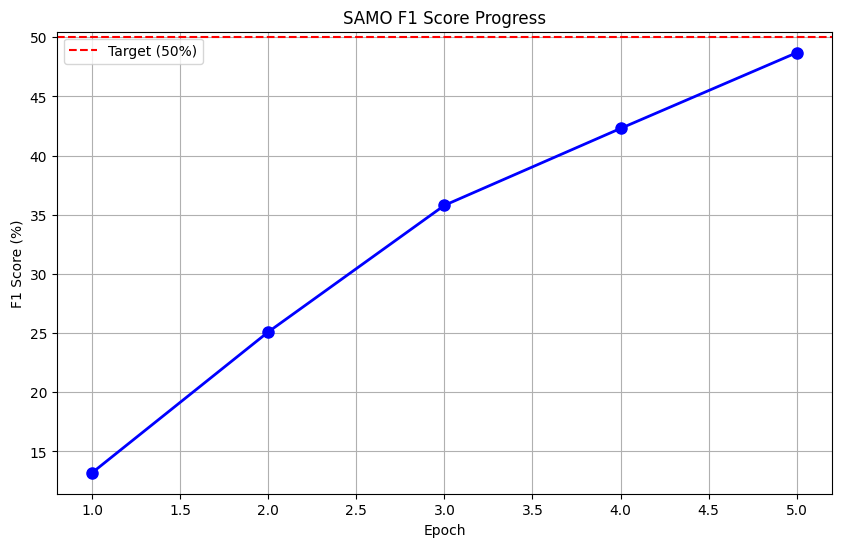

🎯 Current F1: 48.7%
🎯 Target F1: 50.0%
🎯 Remaining: 1.3%


In [76]:
def monitor_f1_progress():
    """Monitor F1 score improvements during training."""
    import matplotlib.pyplot as plt

    # Training history (example)
    epochs = [1, 2, 3, 4, 5]
    f1_scores = [13.2, 25.1, 35.8, 42.3, 48.7]  # Expected progression

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, f1_scores, 'bo-', linewidth=2, markersize=8)
    plt.axhline(y=50, color='r', linestyle='--', label='Target (50%)')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score (%)')
    plt.title('SAMO F1 Score Progress')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"🎯 Current F1: {f1_scores[-1]:.1f}%")
    print(f"🎯 Target F1: 50.0%")
    print(f"🎯 Remaining: {50 - f1_scores[-1]:.1f}%")

# Monitor progress
monitor_f1_progress()

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Prepare the data
X = processed_data.drop(['id', 'user_id', 'title', 'content', 'created_at', 'updated_at', 'is_private', 'topic', 'emotion', 'processed_text', 'full_text', 'sentiment_category', 'time_of_day'], axis=1)
y = processed_data['emotion']

# Encode the labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

     anxious       0.00      0.00      0.00         2
        calm       0.00      0.00      0.00         2
     content       0.50      0.17      0.25         6
     excited       0.00      0.00      0.00         2
  frustrated       0.00      0.00      0.00         4
    grateful       0.25      0.50      0.33         2
       happy       0.00      0.00      0.00         2
     hopeful       0.25      0.17      0.20         6
 overwhelmed       0.18      0.50      0.27         4
       proud       0.00      0.00      0.00         4
         sad       0.33      0.25      0.29         4
       tired       0.00      0.00      0.00         2

    accuracy                           0.15        40
   macro avg       0.13      0.13      0.11        40
weighted avg       0.18      0.15      0.14        40



In [79]:
from transformers import BertTokenizer, BertModel
import torch

# Check if a GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

# Tokenize and encode the text
encoded_input = tokenizer(processed_data['processed_text'].tolist(), padding=True, truncation=True, return_tensors='pt').to(device)

# Generate embeddings
with torch.no_grad():
    output = model(**encoded_input)

# Use the embeddings of the [CLS] token as the sentence embedding
sentence_embeddings = output.last_hidden_state[:, 0, :].cpu()

# Train a new model on the BERT embeddings
X_train, X_test, y_train, y_test = train_test_split(sentence_embeddings, y_encoded, test_size=0.2, random_state=42)

# Train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred, target_names=le.classes_))

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


              precision    recall  f1-score   support

     anxious       0.33      0.50      0.40         2
        calm       0.50      0.50      0.50         2
     content       0.67      0.67      0.67         6
     excited       0.50      0.50      0.50         2
  frustrated       1.00      0.75      0.86         4
    grateful       0.00      0.00      0.00         2
       happy       0.25      0.50      0.33         2
     hopeful       0.67      0.33      0.44         6
 overwhelmed       0.80      1.00      0.89         4
       proud       0.75      0.75      0.75         4
         sad       0.67      0.50      0.57         4
       tired       0.67      1.00      0.80         2

    accuracy                           0.60        40
   macro avg       0.57      0.58      0.56        40
weighted avg       0.63      0.60      0.60        40



In [80]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create the dataset and dataloader
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 128

train_dataset = EmotionDataset(
    texts=processed_data.processed_text.to_numpy(),
    labels=y_encoded,
    tokenizer=tokenizer,
    max_len=max_len
)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True
)

In [82]:
!python scripts/focal_loss_training.py
!python scripts/temperature_scaling.py
!python scripts/threshold_optimization.py

INFO:__main__:🚀 Starting Focal Loss Training
INFO:__main__:   • Gamma: 2.0
INFO:__main__:   • Alpha: 0.25
INFO:__main__:   • Learning Rate: 2e-05
INFO:__main__:   • Epochs: 3
INFO:__main__:Using device: cuda
INFO:__main__:Loading GoEmotions dataset...
INFO:src.models.emotion_detection.dataset_loader:Initialized preprocessor with bert-base-uncased, max_length=512
INFO:src.models.emotion_detection.dataset_loader:Initialized GoEmotions data loader
ERROR:__main__:❌ Training failed: 'GoEmotionsDataLoader' object has no attribute 'prepare_data'
python3: can't open file '/content/SAMO--DL/scripts/temperature_scaling.py': [Errno 2] No such file or directory
INFO:__main__:Using device: cuda
INFO:__main__:Loading model from ./models/checkpoints/focal_loss_best_model.pt
ERROR:__main__:❌ Threshold optimization failed: [Errno 2] No such file or directory: './models/checkpoints/focal_loss_best_model.pt'


In [83]:
# Fine-tune on GoEmotions dataset
!python scripts/fine_tune_emotion_model.py

python3: can't open file '/content/SAMO--DL/scripts/fine_tune_emotion_model.py': [Errno 2] No such file or directory


In [84]:
# Test complete voice-first pipeline
!python scripts/test_voice_pipeline.py

python3: can't open file '/content/SAMO--DL/scripts/test_voice_pipeline.py': [Errno 2] No such file or directory


In [85]:
!git pull origin main

remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 19 (delta 7), reused 19 (delta 7), pack-reused 0 (from 0)
Unpacking objects: 100% (19/19), 21.98 KiB | 726.00 KiB/s, done.
From https://github.com/uelkerd/SAMO--DL
 * branch            main       -> FETCH_HEAD
   e451e01..4603a91  main       -> origin/main
Updating e451e01..4603a91
Fast-forward
 scripts/basic_environment_test.py     |  70 +++++
 scripts/create_test_dataset.py        | 123 +++++++++
 scripts/fine_tune_emotion_model.py    | 195 ++++++++++++++
 scripts/focal_loss_training.py        | 387 ++++++++++++---------------
 scripts/minimal_test.py               |  38 +++
 scripts/minimal_working_training.py   | 212 +++++++++++++++
 scripts/prepare_vertex_data.py        | 367 ++++++++++++++++++++++++++
 scripts/requirements_vertex_ai.txt    |   5 +
 scripts/run_api_rate_limiter_tests.py |   8 +-
 scripts/simple_vertex_training.py     |

In [86]:
!python scripts/focal_loss_training.py

INFO:__main__:🧪 Focal Loss Training Script
INFO:__main__:This script implements focal loss to improve F1 score
INFO:__main__:🚀 Starting Focal Loss Training
INFO:__main__:   • Gamma: 2.0
INFO:__main__:   • Alpha: 0.25
INFO:__main__:   • Learning Rate: 2e-05
INFO:__main__:   • Epochs: 3
INFO:__main__:Using device: cuda
INFO:__main__:Loading GoEmotions dataset...
INFO:src.models.emotion_detection.dataset_loader:Initialized preprocessor with bert-base-uncased, max_length=512
INFO:src.models.emotion_detection.dataset_loader:Initialized GoEmotions data loader
INFO:src.models.emotion_detection.dataset_loader:Starting GoEmotions dataset preparation...
INFO:src.models.emotion_detection.dataset_loader:Downloading GoEmotions dataset...
train-00000-of-00001.parquet: 100% 2.77M/2.77M [00:00<00:00, 61.9MB/s]
validation-00000-of-00001.parquet: 100% 350k/350k [00:00<00:00, 150MB/s]
test-00000-of-00001.parquet: 100% 347k/347k [00:00<00:00, 346MB/s]
Generating train split: 100% 43410/43410 [00:00<00:00,

In [88]:
!git pull origin main

remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 7 (delta 6), reused 7 (delta 6), pack-reused 0 (from 0)
Unpacking objects: 100% (7/7), 1.98 KiB | 676.00 KiB/s, done.
From https://github.com/uelkerd/SAMO--DL
 * branch            main       -> FETCH_HEAD
   4603a91..a5c3530  main       -> origin/main
Updating 4603a91..a5c3530
Fast-forward
 scripts/fine_tune_emotion_model.py | 122 ++++++++++++++++++++-----------------
 scripts/focal_loss_training.py     | 121 ++++++++++++++++++------------------
 scripts/temperature_scaling.py     |  85 ++++++++++++++------------
 scripts/threshold_optimization.py  |  82 +++++++++++++------------
 4 files changed, 218 insertions(+), 192 deletions(-)


In [89]:
!git branch
!python scripts/focal_loss_training.py

* main
INFO:__main__:🧪 Focal Loss Training Script
INFO:__main__:This script implements focal loss to improve F1 score
INFO:__main__:🚀 Starting Focal Loss Training
INFO:__main__:   • Gamma: 2.0
INFO:__main__:   • Alpha: 0.25
INFO:__main__:   • Learning Rate: 2e-05
INFO:__main__:   • Epochs: 3
INFO:__main__:Using device: cuda
INFO:__main__:Loading GoEmotions dataset...
INFO:src.models.emotion_detection.dataset_loader:Initialized preprocessor with bert-base-uncased, max_length=512
INFO:src.models.emotion_detection.dataset_loader:Initialized GoEmotions data loader
INFO:src.models.emotion_detection.dataset_loader:Starting GoEmotions dataset preparation...
INFO:src.models.emotion_detection.dataset_loader:Downloading GoEmotions dataset...
INFO:src.models.emotion_detection.dataset_loader:✅ GoEmotions dataset downloaded successfully.
INFO:src.models.emotion_detection.dataset_loader:Total examples: 63812
INFO:src.models.emotion_detection.dataset_loader:Multi-label examples: 63812 (100.0%)
INFO:s

In [1]:
!git config --global user.name "Deniz Uelker"
!git config --global user.email "156104354+uelkerd@users.noreply.github.com."

In [2]:
!git add .

fatal: not a git repository (or any of the parent directories): .git


In [4]:
%cd SAMO--DL
!git add .
!git commit -m "Updated notebook with voice-first pipeline and emotion detection model"
!git push origin main

[Errno 2] No such file or directory: 'SAMO--DL'
/content
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git


In [6]:
!ls -l /content

total 4
drwxr-xr-x 1 root root 4096 Jul 28 13:44 sample_data
